In [13]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph_agent_101")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph_agent_101


In [14]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

# 도구 실행
tool.invoke("테디노트 랭체인 튜토리얼")

[{'title': '랭체인(langchain) + PDF 기반 질의응답(Question-Answering) (8) - 테디노트',
  'url': 'https://teddylee777.github.io/langchain/langchain-tutorial-08/',
  'content': '⑥ 테스트\n태그:\nChatGPT,\nChatOpenAI,\nGPT3.5,\nGPT4,\nlangchain,\nlangchain tutorial,\nOpenAI,\nPDF,\n랭체인,\n랭체인 튜토리얼,\n문서요약,\n질의응답,\n크롤링\n카테고리:\nlangchain\n업데이트: 2023년 10월 13일\n참고\n[Assistants API] Code Interpreter, Retrieval, Functions 활용법\n2024년 02월 13일\n35 분 소요\nOpenAI의 LangChain 한국어 튜토리얼\n바로가기 👀\n랭체인(langchain) + PDF 기반 질의응답(Question-Answering) (8)\n2023년 10월 13일\n2 분 소요\n이번 포스팅에서는 랭체인(LangChain) 을 활용하여 PDF 문서를 로드하고, 문서의 내용에 기반하여 질의응답(Question-Answering) 하는 방법에 대해 알아보겠습니다.\n 후반부에는 langchain hub 에서 프롬프트를 다운로드 받고, 이를 ChatGPT 모델과 결합하여 문서에 기반한 질의응답 Chain 을 생성합니다.\n✔️ (이전글) LangChain 튜토리얼\n🌱 환경설정\n🔥 PDF 기반 질의 응답(Question-Answering)\n다음은 비구조화된 데이터를 QA 체인(Question-Answering chain) 으로 변환하는 파이프라인에 대한 기술적 번역입니다:\n데이터 로드: 우선, 데이터를 로드해야 합니다. 특히, Assistant API 가 제공하는 도구인 Code Interpreter, Retrieval...\n[LangChain] 에이전트(Agent)와 도구(tools)를

In [15]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

# LLM 초기화
llm = ChatOllama(model="phi4:latest")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

In [16]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

# LLM 초기화
llm = ChatOllama(model="phi4:latest")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

In [17]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

In [18]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [19]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

In [20]:
from langgraph.graph import START, END


def route_tools(state: State):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()


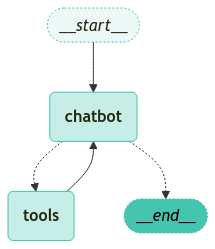

In [11]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)


In [21]:
from langchain_teddynote.messages import display_message_tree

question = "테디노트 YouTube"

for event in graph.stream({"messages": [("user", question)]}):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        display_message_tree(value["messages"][-1])


ResponseError: registry.ollama.ai/library/phi4:latest does not support tools (status code: 400)